# **Bag of Visual Words(BoVW):** <br>
BoVW is a commonly used technique in image classification. The idea behind this technique, is similar to the bag of words in NLP but in this technique we use image features as words.

Step by Step Bag Of Visual Words:

- We extract local features from several images using SIFT/ORB.
- Quantize the feature space. Make this operation via clustering algorithms such as K-means. The center points, that we get from the clustering algorithm, are our visual words.
- Extract local features and compare these features with visual words to create histograms for each image both for the test and train dataset.
- Predict the class of test images comparing with each histogram of train images. We will use 1-NN to predict the class of each test image.
- Calculate the accuracy.


## **Downloading Data**

Kaggle Cats and Dogs Dataset is the available at: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In your local system, you can manually downlaod and unzip the data. You can also work in colab and use following commands to download data files. (Alternatively, you can store your files in Google Drive and read it from there).

In [1]:
# download data 
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
# extract data
!unzip -q kagglecatsanddogs_3367a.zip

--2020-12-09 02:12:58--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.193.24.126, 2600:1417:76:58e::e59, 2600:1417:76:586::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.193.24.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_3367a.zip’

kagglecatsanddogs_3 100%[===================>] 786.68M   157MB/s    in 5.1s    

2020-12-09 02:13:03 (155 MB/s) - ‘kagglecatsanddogs_3367a.zip’ saved [824894548/824894548]



### **Splitting Data**

We will use the python package `split-folder` to distribute dataset into traning and test sets. available at: https://pypi.org/project/split-folders/. The default data after unzipping look like this:
```
input/
    class1/
        img1.jpg
        img2.jpg
        ...
    class2/
        imgWhatever.jpg
        ...
    ...

```

After splitting folder it will look like:

```
output/
    train/
        class1/
            img1.jpg
            ...
        class2/
            imga.jpg
            ...
    val/
        class1/
            img2.jpg
            ...
        class2/
            imgb.jpg
            ...
    test/
        class1/
            img3.jpg
            ...
        class2/
            imgc.jpg
            ...
```

Use the following command to install package:

In [2]:
!pip install split-folders

Lets split the data into train and test with ratios 0.7 and 0.3 respectively.

In [3]:
# or import split_folders
import splitfolders

# Split with a ratio.
# To only split into training and test set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("PetImages", output="output", 
                   seed=1337, ratio=(.7, .3), group_prefix=None) # default values

Copying files: 25002 files [00:05, 4956.72 files/s]


## **Importing Packages**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm.notebook import tqdm
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans

## **Loading datasets**

- takes all images and convert them to grayscale. 
- return a dictionary that holds all images category by category. 

In [5]:

def load_images_from_folder(folder):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        print("Path :" ,path)
        for file in tqdm(os.listdir(path)):
          #print("File Name: ",filename)
          img = cv2.imread(os.path.join(path,file) ,cv2.IMREAD_GRAYSCALE)
          if img is not None:
            img = cv2.resize(img, (120, 120))
            category.append(img)
        images[filename] = category
    return images

images = load_images_from_folder('./output/train')
test = load_images_from_folder('./output/val')

Path : ./output/train/Dog



Path : ./output/train/Cat



Path : ./output/val/Dog



Path : ./output/val/Cat


In [6]:
# Access a category of image like this:
print(type(images.get("Dog")))

<class 'list'>


## **Visualizing Data**

Lets visualize some of the images from both these sets. In order to visualize, we will make use of images and test dictionaries we created while loading the data.

To access any index, it is suggested to get dictionary of the category and then access it by index.

Visualizing data after Train
Visualizing data after Test


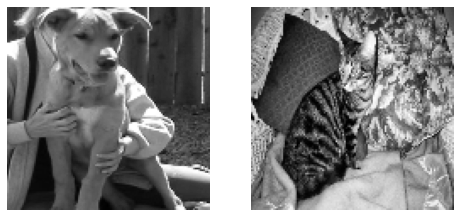

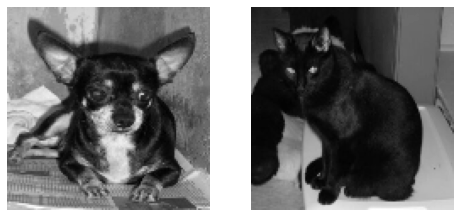

In [7]:
print("Visualizing data after Train")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
# accessing Dogs category in images i.e. train set
ax1.imshow(images.get("Dog")[10], cmap=plt.cm.gray)

ax2.axis('off')
# accessing Cats category in images i.e. train set
ax2.imshow(images.get("Cat")[20], cmap=plt.cm.gray)


print("Visualizing data after Test")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
# accessing Dogs category in test i.e. test set
ax1.imshow(test.get("Dog")[11], cmap=plt.cm.gray)

ax2.axis('off')
# accessing Cat category in test i.e. test set
ax2.imshow(test.get("Cat")[13], cmap=plt.cm.gray)
#ax2.set_title('has Label ' + str(data[12502][1]))

## **Feature Extraction**

Extracts local features from images using SIFT. The below function returns an array whose first index holds a list that holds all local features from all images without an order. This is our visual dictionary. And the second index holds the sift vectors dictionary which holds the descriptors but this is separated class by class

Important step here are:

- Creates descriptors using sift 
- Takes one parameter that is images dictionary
- Return an array whose first index holds the decriptor_list without an order
- And the second index holds the orb_vectors dictionary which holds the descriptors but this is seperated class by class

In [8]:
def orb_features(images):
    orb_vectors = {}
    descriptor_list = []
    orb = cv2.ORB_create()
    for key,value in images.items():
        features = []
        for img in tqdm(value):
            kp, des = orb.detectAndCompute(img,None)
            #if kp/descriptor are detected
            if des is not None:
              descriptor_list.extend(des)
            
            features.append(des)
        orb_vectors[key] = features
    return [descriptor_list, orb_vectors]

ORBs = orb_features(images) 
# Takes the descriptor list which is unordered one
descriptor_list = ORBs[0] 
# Takes the ORB features that is seperated class by class for train data
all_bovw_feature = ORBs[1] 
# Takes the ORB features that is seperated class by class for test data

ORBs_test = orb_features(test)
test_descriptor_list = ORBs_test[0]
test_bovw_feature = ORBs_test[1] #directly accessed descriptor_list here using [1] index

## **Find Visual Words using k-means:**
**NOTE:** To create visual dictionary, we only use train dataset. 

Send the visual dictionary to the k-means clustering algorithm and find the visual words which are center points.


The following function:

- takes 2 parameter which is number 
- of cluster(k) and the other is descriptors list
- Returns an array that holds central points.

In [9]:
def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10,verbose=True, max_iter=300)
    print("...")
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words
    
# Takes the central points which is visual words
# It is suggest to make experiments with cluster centroid and observe its imapact on accuracies    
visual_words = kmeans(30, descriptor_list) 

Streaming output truncated to the last 5000 lines.
done sorting
end inner loop
Iteration 250, inertia 257601506615.33267
start iteration
done sorting
end inner loop
Iteration 251, inertia 257600434781.7466
start iteration
done sorting
end inner loop
Iteration 252, inertia 257599438260.7655
start iteration
done sorting
end inner loop
Iteration 253, inertia 257598477593.52066
start iteration
done sorting
end inner loop
Iteration 254, inertia 257597532344.28336
start iteration
done sorting
end inner loop
Iteration 255, inertia 257596627794.4667
start iteration
done sorting
end inner loop
Iteration 256, inertia 257595785413.22598
start iteration
done sorting
end inner loop
Iteration 257, inertia 257594983861.91544
start iteration
done sorting
end inner loop
Iteration 258, inertia 257594201143.8036
start iteration
done sorting
end inner loop
Iteration 259, inertia 257593431861.88095
start iteration
done sorting
end inner loop
Iteration 260, inertia 257592684717.31094
start iteration
done so

## **Histogram Creation**

Create histograms for both test and train images. 

The following heplper function returns the closest center point.
- It Takes 2 parameters the first one is a ORB descriptor and the second one is the array of central points in k means
- Returns the index of the closest central point.

In [10]:
  def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i]) 
           #count = L1_dist(image, center[i])
        else:
            dist = distance.euclidean(image, center[i]) 
            #dist = L1_dist(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

Lets create histogram for each image using the descriptor and centroids. The following funciton:

- Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class 
- And the second parameter is an array that holds the central points (visual words) of the k means clustering
- Returns a dictionary that holds the histograms for each images that are separated class by class. 

In [11]:
def image_class(all_bovw, centers):
  dict_feature = {}
  for key,value in all_bovw.items():
      category = []
      for img in tqdm(value):
          histogram = np.zeros(len(centers))
          if img is None:
            continue
          for each_feature in img:
              ind = find_index(each_feature, centers)
              histogram[ind] += 1
          category.append(histogram)
      dict_feature[key] = category
  return dict_feature
    
# Creates histograms for train data    
bovw_train = image_class(all_bovw_feature, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_bovw_feature, visual_words) 

## **Classification:**

Predict the class of test images comparing with each histogram of train images. We will use 1-NN to predict the class of each test image.

For more details about KNN visit this [link](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761).

Parametric details for following function are:

- 1-NN algorithm. We use this for predict the class of test images.
- Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
- Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively

In [12]:
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in tqdm(test_val):
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    
# Call the knn function    
results_bowl = knn(bovw_train, bovw_test) 

## **Results**

Lets Calculate the average accuracy and class based accuracies. 

In [13]:
 
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print(key + " : %" + str(acc))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl)

Average accuracy: %54.21010425020049

Class based accuracies: 

Dog : %54.75427350427351
Cat : %53.665061530230076
